# Job Market Analysis Using SQL (Remote OK)

This notebook analyzes remote job postings collected from the Remote OK public feed.The analysis focuses on comparing skill demand across role families(Engineering, Analytics, AI/ML, QA).

In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../data/jobs.db")

def show(query, title):
    print("\n---", title, "---")
    display(pd.read_sql_query(query, conn))

# 1) Role counts
show("""
SELECT role_group, COUNT(*) AS n_jobs
FROM jobs
GROUP BY role_group
ORDER BY n_jobs DESC;
""", "Role counts")

# 2) Top skills overall
show("""
SELECT s.skill_name, COUNT(*) AS n_jobs_mentioning
FROM job_skills js
JOIN skills s ON s.skill_id = js.skill_id
GROUP BY s.skill_name
ORDER BY n_jobs_mentioning DESC;
""", "Top skills overall")

# 3) Skills by role group (counts)
show("""
SELECT j.role_group, s.skill_name, COUNT(*) AS n
FROM jobs j
JOIN job_skills js ON j.job_id = js.job_id
JOIN skills s ON s.skill_id = js.skill_id
GROUP BY j.role_group, s.skill_name
ORDER BY j.role_group, n DESC;
""", "Skills by role group")

# 4) Skill share within each role group (percentage)
show("""
WITH role_totals AS (
  SELECT role_group, COUNT(DISTINCT job_id) AS total_jobs
  FROM jobs
  GROUP BY role_group
),
skill_counts AS (
  SELECT j.role_group, s.skill_name, COUNT(DISTINCT j.job_id) AS jobs_with_skill
  FROM jobs j
  JOIN job_skills js ON j.job_id = js.job_id
  JOIN skills s ON s.skill_id = js.skill_id
  GROUP BY j.role_group, s.skill_name
)
SELECT
  sc.role_group,
  sc.skill_name,
  sc.jobs_with_skill,
  rt.total_jobs,
  ROUND(100.0 * sc.jobs_with_skill / rt.total_jobs, 1) AS pct_of_role
FROM skill_counts sc
JOIN role_totals rt ON rt.role_group = sc.role_group
ORDER BY sc.role_group, pct_of_role DESC;
""", "Skill share within role group (%)")

# 5) How many jobs mention BOTH SQL and Python?
show("""
SELECT COUNT(DISTINCT j.job_id) AS jobs_with_sql_and_python
FROM jobs j
WHERE EXISTS (
  SELECT 1 FROM job_skills js
  JOIN skills s ON s.skill_id = js.skill_id
  WHERE js.job_id = j.job_id AND s.skill_name = 'SQL'
)
AND EXISTS (
  SELECT 1 FROM job_skills js
  JOIN skills s ON s.skill_id = js.skill_id
  WHERE js.job_id = j.job_id AND s.skill_name = 'Python'
);
""", "Jobs with SQL + Python together")

conn.close()


--- Role counts ---


,role_group,n_jobs
0,Other,59
1,Engineering,27
2,Analytics,10
3,AI/ML,2
4,QA,1



--- Top skills overall ---


,skill_name,n_jobs_mentioning
0,AWS,11
1,SQL,9
2,Python,8
3,Excel,7
4,Spark,3
5,Tableau,1
6,R,1
7,Power BI,1



--- Skills by role group ---


,role_group,skill_name,n
0,Analytics,SQL,5
1,Analytics,Python,3
2,Analytics,Excel,2
3,Analytics,Tableau,1
4,Analytics,Spark,1
5,Analytics,Power BI,1
6,Engineering,AWS,9
7,Engineering,SQL,4
8,Engineering,Python,4
9,Engineering,Spark,1



--- Skill share within role group (%) ---


,role_group,skill_name,jobs_with_skill,total_jobs,pct_of_role
0,Analytics,SQL,5,10,50.0
1,Analytics,Python,3,10,30.0
2,Analytics,Excel,2,10,20.0
3,Analytics,Power BI,1,10,10.0
4,Analytics,Spark,1,10,10.0
5,Analytics,Tableau,1,10,10.0
6,Engineering,AWS,9,27,33.3
7,Engineering,Python,4,27,14.8
8,Engineering,SQL,4,27,14.8
9,Engineering,Excel,1,27,3.7



--- Jobs with SQL + Python together ---


,jobs_with_sql_and_python
0,4


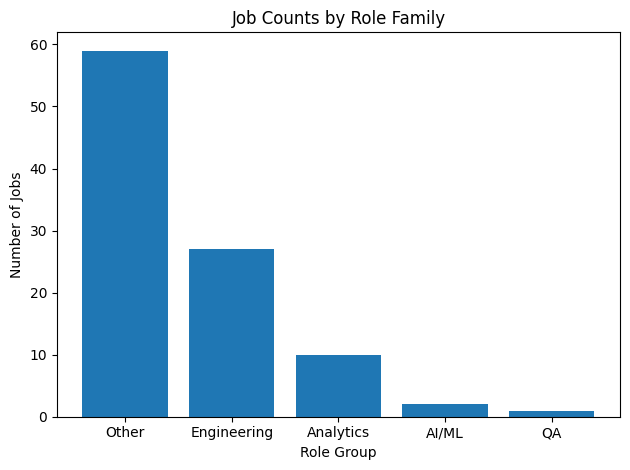

In [3]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect("../data/jobs.db")

df_roles = pd.read_sql_query("""
SELECT role_group, COUNT(*) AS n_jobs
FROM jobs
GROUP BY role_group
ORDER BY n_jobs DESC;
""", conn)

conn.close()

roles = df_roles["role_group"].tolist()
counts = df_roles["n_jobs"].tolist()

plt.figure()
plt.bar(roles, counts)
plt.title("Job Counts by Role Family")
plt.xlabel("Role Group")
plt.ylabel("Number of Jobs")
plt.tight_layout()
plt.show()

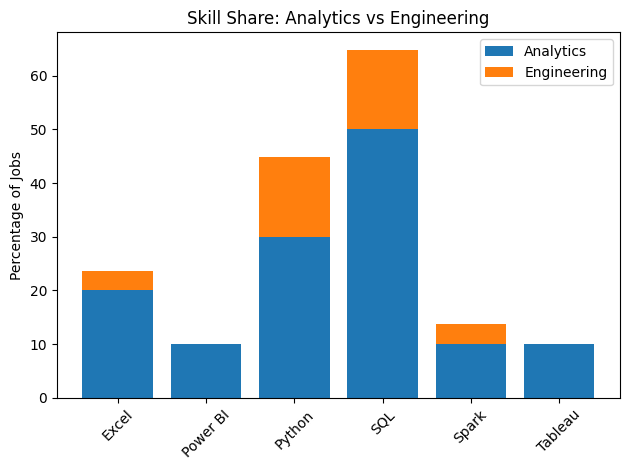

In [4]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# 1) Connect to DB
conn = sqlite3.connect("../data/jobs.db")

# 2) Load skill share data
df = pd.read_sql_query("""
WITH role_totals AS (
  SELECT role_group, COUNT(DISTINCT job_id) AS total_jobs
  FROM jobs
  GROUP BY role_group
),
skill_counts AS (
  SELECT j.role_group, s.skill_name, COUNT(DISTINCT j.job_id) AS jobs_with_skill
  FROM jobs j
  JOIN job_skills js ON j.job_id = js.job_id
  JOIN skills s ON s.skill_id = js.skill_id
  WHERE j.role_group IN ('Analytics', 'Engineering')
  GROUP BY j.role_group, s.skill_name
)
SELECT
  sc.role_group,
  sc.skill_name,
  ROUND(100.0 * sc.jobs_with_skill / rt.total_jobs, 1) AS pct
FROM skill_counts sc
JOIN role_totals rt ON rt.role_group = sc.role_group
ORDER BY sc.skill_name, sc.role_group;
""", conn)

conn.close()

# 3) Separate roles
analytics = df[df["role_group"] == "Analytics"]
engineering = df[df["role_group"] == "Engineering"]

skills = analytics["skill_name"].tolist()
analytics_pct = analytics["pct"].tolist()

engineering_pct = []
for s in skills:
    row = engineering[engineering["skill_name"] == s]
    if len(row) > 0:
        engineering_pct.append(row["pct"].values[0])
    else:
        engineering_pct.append(0)

# 4) Plot
x = range(len(skills))

plt.figure()
plt.bar(x, analytics_pct, label="Analytics")
plt.bar(x, engineering_pct, bottom=analytics_pct, label="Engineering")

plt.xticks(x, skills, rotation=45)
plt.ylabel("Percentage of Jobs")
plt.title("Skill Share: Analytics vs Engineering")
plt.legend()
plt.tight_layout()
plt.show()